In [1]:
from typing import *
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_histogram
from qiskit import QuantumCircuit, assemble, Aer
sim = Aer.get_backend('aer_simulator')

zero = Statevector([1.0 + 0j, 0j])  # 0 qubit
one = Statevector([0j, 1.0 + 0j])   # 1 qubit

def enum_bits(n):
    if n == 1:
        return [[False], [True]]
    else:
        acc = []
        for x in enum_bits(n-1):
            acc += [[False] + x]
            acc += [[True] + x]
        return acc

## Lecture 12: Simon's Algorithm

References
1. [Introduction to Classical and Quantum Computing: Chapter 7](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [https://qiskit.org/textbook/ch-algorithms/simon.html](https://qiskit.org/textbook/ch-algorithms/simon.html)

## Where Were We?

1. Last time: introduced our first quantum algorithm, the Deutsch-Jozsa Algorithm.
2. Today: introduce a non-trivial quantum algorithm, Simon's algorithm.
3. Next time: midterm

## Algorithm Roadmap

1. Deutsch-Jozsa: first quantum algorithm to demonstrate exponential speedup compared to deterministic classical algorithm.
2. **Simon's Algorithm**: first quantum algorithm to demonstrate exponential speedup compared to classical probabilistic algorithm.
3. Grover's Search: blackbox quantum speedup.

Shor's algorithm
1. Quantum Fourier Transform: building block for Shor's algorithm.
2. Quantum Phase Estimation: building block for Shor's algorithm.
3. Shor's Algorithm: can efficiently crack public-key cryptography.

## Simon's Problem

1. Before we can give Simon's algorithm, we should introduce the problem that it is solving.
2. Simon's algorithm was the first quantum algorithm that demonstrated exponential speedup compared to a classical probabilistic algorithm.

### One-to-one function

A function $f: \{0, 1\}^n \rightarrow \{0, 1\}^n$ is **one-to-one** if 
$$
f(x) = f(y)
$$
iff $x = y$, i.e., it maps unique bitstrings to unique bitstrings.

In [2]:
# one-to-one
def neg_all(x: list[bool]) -> list[bool]:
    return [not b for b in x]

print(neg_all([False, False]))
print(neg_all([False, True]))
print(neg_all([True, False]))
print(neg_all([True, True]))

[True, True]
[True, False]
[False, True]
[False, False]


In [3]:
# not one-to-one
def f(x: list[bool]) -> list[bool]:
    return [x[len(x)-1]] + [x[i] and x[i+1] for i in range(len(x)-1)]

print(f([False, False])) # <- non-unique
print(f([False, True]))
print(f([True, False]))  # <- non-unique
print(f([True, True]))

[False, False]
[True, False]
[False, False]
[True, True]


### Two-to-one function

A function $f: \{0, 1\}^n \rightarrow \{0, 1\}^n$ is **two-to-one** if for every unique output $z$,
$$
z = f(x) = f(y)
$$
for exactly two $x \neq y$, i.e., it maps each pair of unique bit-strings to the same output.

1. Equivalently, let $b \in \{0, 1\}^n \neq 0$ be a bit string. Then $f$ is two-to-one if $f(x) = f(y)$ iff $y = x \oplus b$.
2. Note that $b = 0\dots0$ corresponds to the case that f is a one-to-one function.

In [4]:
def mk_two2one_nbit(n) -> list[bool]:
    b = [True] + [random.choice([True, False]) for i in range(n-1)]
    xs = enum_bits(len(b))
    out = enum_bits(len(b)); random.shuffle(out); i = 0
    mapping = {}; seen = set()
    for x in xs:
        y = [c != d for c, d in zip(x, b)]
        sx = str(x); sy = str(y);
        if sx in seen or sy in seen:
            continue
        mapping[sx] = out[i]; mapping[sy] = out[i]; i += 1
        seen.add(sx); seen.add(sy)
    
    return lambda x: mapping[str(x)]

In [5]:
g2 = mk_two2one_nbit(2)
print(g2([False, False]))
print(g2([False, True]))
print(g2([True, False]))
print(g2([True, True]))

[True, True]
[False, False]
[False, False]
[True, True]


In [6]:
g3 = mk_two2one_nbit(3)
for b in enum_bits(3):
    print(g3(b))

[False, True, True]
[True, False, True]
[False, True, False]
[False, False, False]
[False, False, False]
[False, True, False]
[True, False, True]
[False, True, True]


### Problem Definition

Simon's problem is: given a function on bitstrings
$$
f : \{0, 1\}^n \rightarrow \{0, 1\}^n
$$
is either
1. one-to-one function or
2. a two-to-one function,
determine which it is.

Equivalently, given a hidden bit string $b$, determine if $b$ is all 0s or not.

## Classical Solution to Simon's Problem

1. Intuitively, the simplest thing we can do is to check every input and see if we get a one-to-one function or a two-to-one function.
2. We actually "only" need to check one more than half of the inputs since we're dealing with two-to-one functions.

In [7]:
def solve_simons(nbits: int, f: Callable[list[bool], list[bool]]) -> str:
    seen = set()
    inputs = enum_bits(nbits)
    count = 0
    for b in inputs:
        # We only need to check half the inputs
        if count >= len(inputs)/2 + 1:
            break
        count += 1
        
        # Keep track of what we have seen
        y = str(f(b))
        if y in seen:
            return "two-to-one"
        seen.add(y)
    return "one-to-one"

In [8]:
solve_simons(3, neg_all)

'one-to-one'

Text(0.5, 1.0, 'Running Time of Classical Algorithm')

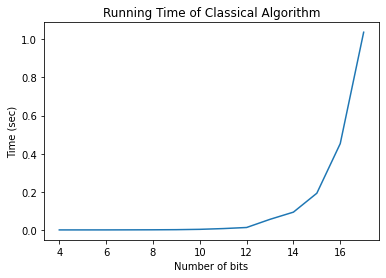

In [9]:
ns = range(4, 18)
times = []
for n in ns:
    start = time.time()
    gn = mk_two2one_nbit(n)
    solve_simons(n, gn)
    times += [time.time() - start]
plt.plot(ns, times)
plt.xlabel('Number of bits'); plt.ylabel('Time (sec)'); plt.title('Running Time of Classical Algorithm')

### Aside: Probabilistic Solution to Simon's Problem

1. What if we allowed for some error?
2. Unlike the Deutsch-Jozsa Problem, it is still hard for us to get a speedup.

#### Why?

1. Intuitively, still need to check half the bit-strings (in the worst case since the two-to-one can be adversarially constructed).
2. This is still exponential.

## Quantum Solution to Simon's Problem

Let's introduce the algorithm before we code it up.

### Algorithm

#### Step 1: Initialize

Create the initial state
$$
|\psi_0 \rangle = |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n}
$$
which is composed of two parts.

#### Step 2: Apply Hadamard to first n qubits

Apply $H^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n}(-1)^{x \cdot y} |x\rangle\langle y|$ to the first $n$ qubits.

Thus
\begin{align*}
|\psi_1 \rangle & = (I^{\otimes n} \otimes H^{\otimes n}) |\psi_0 \rangle \tag{Step 2} \\ 
& = |0\rangle^{\otimes n} \otimes \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n}(-1)^{x \cdot y} |x\rangle\langle y||0\rangle^{\otimes n} \right) \tag{definition $H^{\otimes n}$ and linearity} \\
& = |0\rangle^{\otimes n} \otimes \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{x \cdot |0\rangle^{\otimes n}}|x\rangle \tag{non-zero when $y = |0\rangle^{\otimes n}$} \\
& = |0\rangle^{\otimes n} \otimes \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \tag{dot product is $0$} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |0^{\otimes n}, x\rangle \tag{rearrange}
\end{align*}

#### Step 3: Apply Oracle

Apply the oracle
$$
U_f|y, x\rangle = U_f|y \oplus f(x), x\rangle \,.
$$

Thus
\begin{align*}
|\psi_2\rangle & = H^{\otimes n} |\psi_1\rangle \tag{Step 3} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} U_f |0^{\otimes n}, x\rangle \tag{definition $H^{\otimes n}$ and linearity} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |0^{\otimes n} \oplus f(x), x\rangle \tag{apply oracle} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |f(x), x\rangle \tag{property of xor $\oplus$} \\
\end{align*}

#### Step 4: Measure second n qubits

Measure the second half of $|\psi_2\rangle$ to obtain $f(x)$, which means either $x$ or $y = x \oplus b$ could be the corresponding input.

Therefore the first half of $|\psi_2\rangle$ becomes
$$
|\psi_3\rangle = \frac{1}{\sqrt{2}} (|x\rangle + |y\rangle)
$$
so that the entire quantum state is
$$
|f(x) \rangle \otimes |\psi_3\rangle \,.
$$

#### Step 5: Apply  Hadamard to first n qubits

Apply $H^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n}(-1)^{x \cdot y} |x\rangle\langle y|$ to the first $n$ qubits, i.e., $|\psi_3\rangle$

\begin{align*}
|\psi_4\rangle & = H^{\otimes n} |\psi_3\rangle \tag{Step 5} \\
& = H^{\otimes n} \frac{1}{\sqrt{2}} (|x\rangle + |y\rangle) \tag{substitute $|\psi_4\rangle$} \\
& = \frac{1}{\sqrt{2^{n+1}}} \sum_{w \in \{0, 1\}^n} \sum_{z \in \{0, 1\}^n}(-1)^{w \cdot z} |w\rangle\langle z|(|x\rangle + |y\rangle) \tag{definition H and linearity} \\
& = \frac{1}{\sqrt{2^{n+1}}} \sum_{w \in \{0, 1\}^n} ((-1)^{w \cdot x} + (-1)^{w \cdot y}) |w\rangle \tag{dot product not zero when z = x or z = y} \\
\end{align*}

#### Step 6: Measure first n qubits

Observe:
1. $(-1)^{w \cdot x} = (-1)^{w \cdot y}$: contribution of corresponding $|a\rangle$
2. $(-1)^{w \cdot x} \neq (-1)^{w \cdot y}$: no contribution of corresponding $|w\rangle$

Consequently, upon a single measurement, we will observe some $|w\rangle$ s.t. $w \cdot x = w \cdot y$.
This occurs
\begin{align*}
w \cdot x = a \cdot y & \iff w \cdot x = w \cdot (x \oplus b) \tag{substitute y} \\
& \iff w \cdot x = (w \cdot x) \oplus (w \cdot b) \tag{property of xor $\oplus$} \\
& \iff 0 = w \cdot b \,. \tag{xor both sides by $(w \cdot x)$} \\
\end{align*}

Thus with $\approx n$ queries, we obtain a system of linear equations
\begin{align*}
w_1 \cdot b & = 0 \tag{measurement 1}\\
\vdots & = 0 \\
w_n \cdot b & = 0 \tag{measurement n}\\
\end{align*}

This can be solved in $O(n^3)$ time.

### Code

In [10]:
# Source: https://github.com/qiskit-community/qiskit-textbook/blob/589c64d66c8743c123c9704d9b66cda4d476dbff/qiskit-textbook-src/qiskit_textbook/tools/__init__.py
def simon_oracle(b):
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)
    if '1' not in b: 
        return qc  # 1:1 mapping, so just exit
    i = b.find('1') # index of first non-zero bit in b
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc 

In [11]:
b = '11'
n = len(b)
oracle = simon_oracle(b)

# Step 1: Initialize to all 0s
simon_circuit = QuantumCircuit(n*2, n)

# Step 2: Apply Hadamard gates to first n qubits
simon_circuit.h(range(n))    

# Step 3: Query Oracle
simon_circuit.barrier()
simon_circuit = simon_circuit.compose(oracle)
simon_circuit.barrier()

# Step 4': Can only measure in qiskit at the end, but these results are ignored

# Step 5: Apply Hadamard gates to first n qubits
simon_circuit.h(range(n))

# Step 6: Measure first n qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

┌───┐ ░                      ░ ┌───┐┌─┐   
q_0: ┤ H ├─░───■─────────■────■───░─┤ H ├┤M├───
     ├───┤ ░   │         │    │   ░ ├───┤└╥┘┌─┐
q_1: ┤ H ├─░───┼────■────┼────┼───░─┤ H ├─╫─┤M├
     └───┘ ░ ┌─┴─┐  │  ┌─┴─┐  │   ░ └───┘ ║ └╥┘
q_2: ──────░─┤ X ├──┼──┤ X ├──┼───░───────╫──╫─
           ░ └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║ 
q_3: ──────░──────┤ X ├─────┤ X ├─░───────╫──╫─
           ░      └───┘     └───┘ ░       ║  ║ 
c: 2/═════════════════════════════════════╩══╩═
                                          0  1

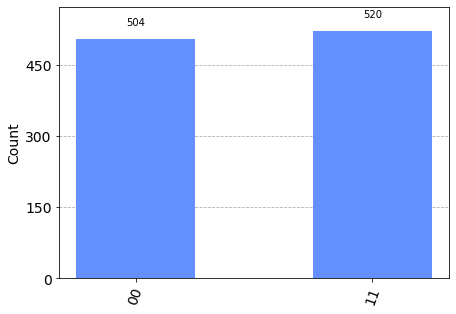

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [13]:
# Source: https://qiskit.org/textbook/ch-algorithms/simon.html

# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

11.11 = 0 (mod 2)
11.00 = 0 (mod 2)


## Summary

1. The classical algorithm for solving Simon's problem requires an exponential number of queries.
2. The quantum algorithm for solving Simon's problem requires just a single query.
3. Simon's algorithm is contrived. Nevertheless, it inspired Shor's algorithm, which is useful.